# LSTM & GRU Models applied to webscraped Tablature dataset

### Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import math
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, GRU, Embedding
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.optimizers import Adam, SGD
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import ast
import tensorflow as tf

from keras.utils import *
from keras.initializers import *
import time, random

import graphviz, pydot

### Ensure GPU's active:

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 997357729536846266
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4857331712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1824842851949932457
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


### Functions:

In [3]:
def tokenize(x, tokenizer):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer
    

def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')

def parse_data(row):
    """
    This function parses a row extracted from the csv file
    
    Example usage:
        train_sample = train.values[4]
        notes, locations = parse_data(train_sample)
    """
    notes = ast.literal_eval(row[1])
    locations = ast.literal_eval(row[2])
    
    out_notes = []
    out_locations = []
    
    for i, line in enumerate(notes):
        out_notes.append(line)
        locs = [locations[i][j] for j,v in enumerate(line)]
        out_locations.append(locs)
        
        #for j, note in enumerate(line):
            #out_notes.append(note)
           # out_locations.append(locations[i][j])
        
    return out_notes, out_locations

def get_next_note(current_note):
    # A simple solution to create a "wheel" of note alphabet
    alphabet = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    for i, note in enumerate(alphabet):
        if note == current_note:
            if i+1 == len(alphabet):
                return alphabet[0]
            else:
                return alphabet[i+1]

def generate_maps():
    """
    Generates the id to note and id to location maps.
    """
    alphabet = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

    note_map = dict()
    loc_map = dict()
    
    counter = 0
    for note in alphabet: # for 7 notes in the alphabet
        for j in range(5): # for 5 octave range of guitar
            octave = j + 2 # starting octave 2
            msg = "{}{} - {}".format(note, octave, counter)
            #print(msg)
            
            key = "{}{}".format(note, octave)
            
            note_map[key] = counter+1 # set note to counter as id e.g. C2 = 1 ; 0 is reserved for padding
            
            counter += 1
    
    #print(note_map)
    note_map_back = dict(map(reversed, note_map.items()))
    #print(note_map_back)
    
    counter = 0
    for string in range(6):
        string += 1
        for fret in range(25):
            #print(string, fret)
            key = (string, fret)
            
            loc_map[key] = counter + 1 
            
            counter += 1
    
    #print(loc_map)
    loc_map_back = dict(map(reversed, loc_map.items()))
    #print(loc_map_back)
    
    return note_map, note_map_back, loc_map, loc_map_back

def logits_to_loc(logits, tokenizer):
    indx = np.argmax(logits[0]) # find the predicted note
    return tokenizer[indx]

def make_note_map():
    alphabet = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
    tuning = [("E", 4), ("B", 3), ("G", 3), ("D",3), ("A", 2), ("E", 2)]
    
    note_map = {}

    for string in range(6):
        current_note = tuning[string][0]
        current_octave = tuning[string][1]
        for fret in range(25):
            loc = (string+1, fret) # 1 added as note counting starts from 1
            note = current_note + str(current_octave)
            #print(note ,loc)
            
            if note in note_map.keys():
                cpy = note_map[note]
                cpy.append(loc)
                note_map[note] = cpy
            else:
                note_map[note] = [loc]
            
            
            if current_note == "B":
                current_octave += 1
            current_note = get_next_note(current_note)
    
    return note_map

def find_note_by_loc(loc, note_map):
    for key in note_map.keys():
        if loc in note_map[key]:
            return key    

def generate_training_data():
    note_map = make_note_map()
    
    jumble = []
    
    for fret_position in range(6):
        seq = []
        
        for string in range(6):
            
            for f in range(4):
                
                actual_fret = f + (fret_position*4)
                loc = (string+1, actual_fret)
                note = find_note_by_loc(loc, note_map)
                seq.append((note,loc))
        jumble.append(seq)
    
    
    # randomly jumble the notes within the position
    note_train, loc_train = [], []
    
    for position in jumble:
        for i in range(1000): # generate 1000 sequences for each position
            
            notes = []
            locs = []
            
            for j in range(100): # each sequence is going to be of length 100
                choice = position[random.randint(0, 23)] # randomly pick an item within that hand position
                notes.append(choice[0])
                locs.append(choice[1])
            
            note_train.append(notes)
            loc_train.append(locs)                

    return note_train, loc_train

### Loading Data:

In [4]:
# Preliminary Training dataset
notes_train, locs_train = generate_training_data()

In [5]:
# Our dataset of tabs
dataset = pd.read_csv("data/tabs.csv", usecols=[0,1,2], engine="python")
train_size = int(len(dataset) * 0.8) # 0.67
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
train = train.drop([244]) # Removing an invalid row

print("Train size: ", len(train))
print("Test size: ", len(test))

train.head()

Train size:  2760
Test size:  691


,filename,notes,positions
0,24kgoldn_city-of-angels-tabs-2998598.txt,"[['A#4', 'F4', 'D4', 'A#3', 'F3'], ['A#4', 'F4...","[[(1, 6), (2, 6), (3, 7), (4, 8), (5, 8)], [(1..."
1,24kgoldn_mood-tabs-3262430.txt,"[['G4', 'D#4', 'A#3'], ['G4', 'D#4', 'A#3'], [...","[[(1, 3), (2, 4), (3, 3)], [(1, 3), (2, 4), (3..."
2,24kgoldn_mood-tabs-3353051.txt,"[['G4', 'D#3'], ['G4', 'D#3'], ['A#4', 'G3'], ...","[[(2, 8), (5, 6)], [(2, 8), (5, 6)], [(2, 11),..."
3,3-doors-down_be-like-that-tabs-150098.txt,"[['G2'], ['G3'], ['D3'], ['G4'], ['D4'], ['G3'...","[[(6, 3)], [(3, 0)], [(4, 0)], [(1, 3)], [(2, ..."
4,3-doors-down_here-without-you-tabs-40873.txt,"[['A2'], ['E3'], ['A3'], ['C4'], ['A3'], ['E3'...","[[(5, 0)], [(4, 2)], [(3, 2)], [(2, 1)], [(3, ..."


### Prepare the data

In [6]:
# Training data
all_train_notes, all_train_locs = [], []
for note, loc in zip(notes_train, locs_train):
    all_train_notes.append(note)
    all_train_locs.append(loc)

In [7]:
# Dataset data
all_notes, all_locs = [], []
for i in train.values:
    try:
        notes, locs = parse_data(i)
    except:
        print("Skipped a song...")
        continue
        
    notes_clean, locs_clean = [], []
    
    for i, val in enumerate(notes):
        for j, note in enumerate(val):
            notes_clean.append(note)
            locs_clean.append(locs[i][j])
            
    
    all_notes.append(notes_clean)
    all_locs.append(locs_clean)

In [8]:
print("Training notes length: ", len(all_train_notes))
print("Training locs length: ", len(all_train_locs))

print("\nDataset notes length: ", len(all_notes))
print("Dataset locs length: ", len(all_locs))

Training notes length:  6000
Training locs length:  6000

Dataset notes length:  2760
Dataset locs length:  2760


#### Validate Dataset:

In [9]:
note_to_loc = make_note_map()

for notes, locs in zip(all_notes, all_locs):
    for i, loc in enumerate(locs):
        note = find_note_by_loc(loc, note_to_loc)
        if note != notes[i]:
            print(loc)
            print("Should be: ",note)
            print("Actually is: ", notes[i])

#### Data Analysis:

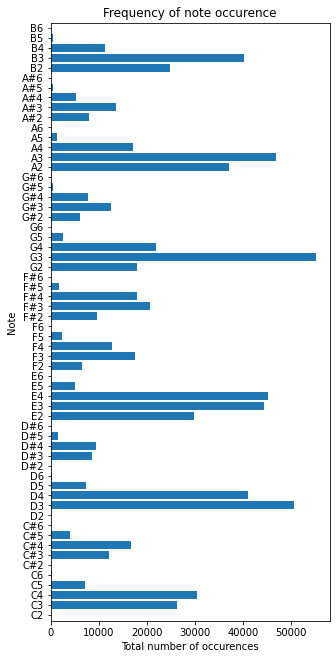

In [10]:
# Check notes coverage
note_map, note_map_back, loc_map, loc_map_back = generate_maps() # Keep this defined

counter_map = {}

# convert the map to counter map
for note in note_map.keys():
    counter_map[note] = 0

for notes in all_notes:
    for indx, note in enumerate(notes):
        new = counter_map[note] + 1
        counter_map[note] = new


x = list(counter_map.keys())
y = list(counter_map.values())
plt.figure(figsize=(5,11))
plt.barh(x, y, align="center")
plt.rcParams["patch.force_edgecolor"] = True

plt.ylim(-0.6, len(counter_map) -0.5 ,.5)

plt.title("Frequency of note occurence")
plt.xlabel("Total number of occurences")
plt.ylabel("Note")

plt.savefig("frequency_occurence.png")

In [11]:
all_notes_length = []
for i in all_notes:
    all_notes_length.append(len(i))

Text(0, 0.5, 'Number of songs')

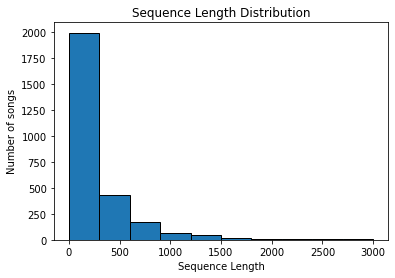

In [12]:
plt.hist(all_notes_length, range=(0,3000))
plt.title("Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Number of songs")

### Preprocess Pipeline

In [13]:
# Obtain max sequence length
max_seq_len = len(max(all_notes, key=len))
max_seq_len = 500
print("Maximum sequence length: ", max_seq_len)

Maximum sequence length:  500


In [14]:
note_map, note_map_back, loc_map, loc_map_back = generate_maps() # Keep this defined

def preprocess(x, y, note_map, loc_tokenizer):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """    
    preprocess_x = []
    for song in x:
        #print(song)
        if len(song) > max_seq_len:
            continue
        temp = []
        for note in song:
            try:
                temp.append(note_map[note])
            except:
                print(song)
            
        preprocess_x.append(temp)
    
    preprocess_y = []
    # Tokenize the locs
    for song in y:
        if len(song) > max_seq_len:
            continue
        temp = []
        for loc in song:
            temp.append(loc_tokenizer[loc])
        preprocess_y.append(temp)
        
    
    preprocess_x = pad(preprocess_x, length = max_seq_len)
    preprocess_y = pad(preprocess_y, length = max_seq_len)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_x = preprocess_x.reshape(*preprocess_x.shape, 1)
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y


preproc_train_notes, preproc_train_locs =\
preprocess(all_train_notes, all_train_locs, note_map, loc_map)

preproc_notes, preproc_locs =\
preprocess(all_notes, all_locs, note_map, loc_map)

max_sequence_length = preproc_notes.shape[1]

note_vocab_size = len(note_map)
loc_vocab_size = len(loc_map)

print('Data Preprocessed Statistics:')
print("-+"*20)
print("Max notes sequence length:", preproc_notes.shape[1])
print("Max locs sequence length:", preproc_locs.shape[1])
print("-+"*20)
print("Max train notes sequence length:", preproc_train_notes.shape[1])
print("Max train locs sequence length:", preproc_train_locs.shape[1])
print("-+"*20)
print("Notes vocab size: ", len(note_map))
print("Locs vocab size: ", len(loc_map))
print("-+"*20)
print("Notes shape: ", preproc_notes.shape)
print("Locs shape: ", preproc_locs.shape)
print("-+"*20)
print("Notes shape: ", preproc_notes.shape)
print("Locs shape: ", preproc_locs.shape)
print("-+"*20)
print("Train notes shape: ", preproc_train_notes.shape)
print("Train locs shape: ", preproc_train_locs.shape)

Data Preprocessed Statistics:
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Max notes sequence length: 500
Max locs sequence length: 500
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Max train notes sequence length: 500
Max train locs sequence length: 500
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Notes vocab size:  60
Locs vocab size:  150
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Notes shape:  (2339, 500, 1)
Locs shape:  (2339, 500, 1)
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Notes shape:  (2339, 500, 1)
Locs shape:  (2339, 500, 1)
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Train notes shape:  (6000, 500, 1)
Train locs shape:  (6000, 500, 1)


In [15]:
# Prepare test data
# Parse
test_notes, test_locs = [], []
for i in test.values:
    try:
        notes, locs = parse_data(i)
    except:
        print("Skipped a song...")
        continue
        
    # Flatten
    notes_clean, locs_clean = [], []
    for i, val in enumerate(notes):
        for j, note in enumerate(val):
            notes_clean.append(note)
            locs_clean.append(locs[i][j])
            
    
    test_notes.append(notes_clean)
    test_locs.append(locs_clean)
    
# Preprocess the data
preproc_test_notes, preproc_test_locs = preprocess(test_notes, test_locs, note_map, loc_map)

print("Test set contais {} songs".format(len(preproc_test_notes)))

Test set contais 577 songs


### Figure out baseline accuracy:

As a baseline for our prediction model. We will choose a random location out of possible notes.

In [16]:
note_to_loc = make_note_map()

baseline_correct = 0
baseline_total = 0

for song_notes, song_locs in zip(test_notes, test_locs):
    for note, loc in zip(song_notes, song_locs):
        
        random_loc = random.choice(note_to_loc[note])
        if loc == random_loc:
            baseline_correct += 1
            
        baseline_total += 1

print("Baseline method got {} out of {}. \t {}%".format(baseline_correct, baseline_total, round((baseline_correct/baseline_total)*100, 3)))

Baseline method got 65268 out of 190969. 	 34.177%


## Models:

### LSTM Model:

In [17]:
# Define the model
def lstm_model(input_shape, output_sequence_length, note_vocab_size, loc_vocab_size):    
    model = Sequential()
    model.add(Embedding(output_dim=loc_vocab_size, input_dim=note_vocab_size, input_length=input_shape[1]))
    model.add(LSTM(512, return_sequences=True, activation="tanh"))
    model.add(TimeDistributed(Dense(loc_vocab_size)))
    model.add(Activation('softmax'))
    
    # Compile model
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

# Reshaping the input to work with a basic RNN
tmp_x_train = pad(preproc_train_notes, max_sequence_length)
tmp_y_train = pad(preproc_train_locs, max_sequence_length)

tmp_x = pad(preproc_notes, max_sequence_length)
tmp_y = pad(preproc_locs, max_sequence_length)

# Train the neural network
lstm_model = lstm_model(
    tmp_x.shape,
    max_sequence_length,
    note_vocab_size,
    loc_vocab_size)

print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 150)          9000      
                                                                 
 lstm (LSTM)                 (None, 500, 512)          1357824   
                                                                 
 time_distributed (TimeDistr  (None, 500, 150)         76950     
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 500, 150)          0         
                                                                 
Total params: 1,443,774
Trainable params: 1,443,774
Non-trainable params: 0
_________________________________________________________________
None


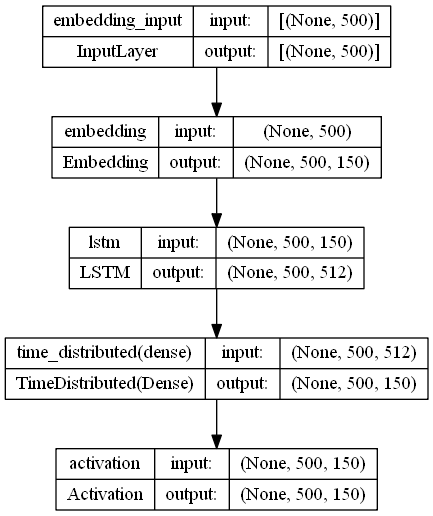

In [18]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True)

#### Train:

In [19]:
# Train the model on training data
lstm_model.fit(tmp_x_train, tmp_y_train, batch_size=10, epochs=5, validation_split=0.2)
# Train the model on actual data
lstm_model.fit(tmp_x, tmp_y, batch_size=10, epochs=10, validation_split=0.2)

Epoch 1/5
480/480 [==============================] - 38s 73ms/step - loss: 1.0583 - accuracy: 0.8014 - val_loss: 1.4259 - val_accuracy: 0.7999
Epoch 2/5
480/480 [==============================] - 35s 72ms/step - loss: 0.6861 - accuracy: 0.8471 - val_loss: 2.2656 - val_accuracy: 0.8070
Epoch 3/5
480/480 [==============================] - 41s 85ms/step - loss: 0.3154 - accuracy: 0.9375 - val_loss: 2.9472 - val_accuracy: 0.8244
Epoch 4/5
480/480 [==============================] - 54s 113ms/step - loss: 0.1291 - accuracy: 0.9860 - val_loss: 3.0833 - val_accuracy: 0.8321
Epoch 5/5
480/480 [==============================] - 67s 140ms/step - loss: 0.0465 - accuracy: 0.9932 - val_loss: 3.5773 - val_accuracy: 0.8328
Epoch 1/10
188/188 [==============================] - 32s 155ms/step - loss: 0.3004 - accuracy: 0.8770 - val_loss: 0.3242 - val_accuracy: 0.8597
Epoch 2/10
188/188 [==============================] - 29s 157ms/step - loss: 0.2495 - accuracy: 0.8892 - val_loss: 0.3036 - val_accuracy: 

#### Test:

In [20]:
test_x_tmp = pad(preproc_test_notes, max_sequence_length)
test_y_tmp = pad(preproc_test_locs, max_sequence_length)

In [21]:
# Run the test
notes_length = 0
notes_correct = 0

locs_length = 0
locs_correct = 0

note_loc_map = make_note_map()

for notes, locs in zip(test_x_tmp, test_y_tmp):
    
    prediction = lstm_model.predict(notes, verbose=False)
    
    for note, actual in zip(prediction, locs):
        actual = actual[0]
        note = note[0]
        
        indx = np.argmax(note) # find the predicted note
        
        if actual == 0 or indx == 0:
            continue # skip end of sequence
        
        # otherwise add 1 to length
        notes_length += 1 
        locs_length += 1
        
        loc_predicted = loc_map_back[indx]
        loc_actual = loc_map_back[actual]
        
        # Find the actual note+octave of the predicted location
        note_predicted = find_note_by_loc(loc_predicted, note_loc_map)
        note_actual = find_note_by_loc(loc_actual, note_loc_map)
        
        #print("Predicted: ", note_predicted,"@",loc_predicted , "\t Actual: ", note_actual, "@", loc_actual)
        
        # Add 1 to locs if loc is correct
        if indx == actual:
            locs_correct += 1
        
        # Add 1 to notes if note is correct
        if note_predicted == note_actual:
            notes_correct += 1
    
    #print("Correct: {} \t Total: {} \t Percentage: {}%".format(correct, total_length, round((correct/total_length) * 100,3)))
    #print("Correct: ", correct)
    #print("Total: ", total_length)

print("Precise location statistics:  {}%".format(round((locs_correct/locs_length)*100, 3)) )
print("Correct note+octave statistics: {}%".format(round((notes_correct/notes_length)*100, 3)) ) 

Precise location statistics:  56.401%
Correct note+octave statistics: 99.98%


### GRU Model:

#### Define:

In [22]:
# Define the model
def gru_model(input_shape, output_sequence_length, note_vocab_size, loc_vocab_size):
    
    model = Sequential()
    model.add(Embedding(output_dim=loc_vocab_size, input_dim=note_vocab_size, input_length=input_shape[1]))
    model.add(GRU(512, return_sequences=True, activation="tanh"))
    model.add(TimeDistributed(Dense(loc_vocab_size)))
    model.add(Activation('softmax'))
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

tmp_x_train = pad(preproc_train_notes, max_sequence_length)
tmp_y_train = pad(preproc_train_locs, max_sequence_length)

tmp_x = pad(preproc_notes, max_sequence_length)
tmp_y = pad(preproc_locs, max_sequence_length)

# Train the neural network
gru_model = gru_model(
    tmp_x.shape,
    max_sequence_length,
    note_vocab_size,
    loc_vocab_size)

print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 150)          9000      
                                                                 
 gru (GRU)                   (None, 500, 512)          1019904   
                                                                 
 time_distributed_1 (TimeDis  (None, 500, 150)         76950     
 tributed)                                                       
                                                                 
 activation_1 (Activation)   (None, 500, 150)          0         
                                                                 
Total params: 1,105,854
Trainable params: 1,105,854
Non-trainable params: 0
_________________________________________________________________
None


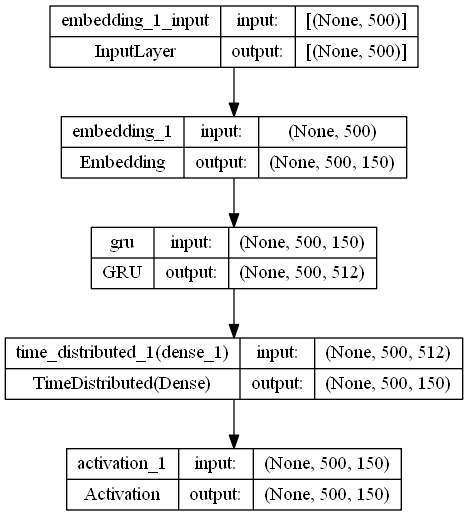

In [23]:
tf.keras.utils.plot_model(gru_model, show_shapes=True)

#### Train:

In [24]:
# Train the model on training data
gru_model.fit(tmp_x_train, tmp_y_train, batch_size=10, epochs=5, validation_split=0.1)
# Train the model on actual data
gru_model.fit(tmp_x, tmp_y, batch_size=10, epochs=10, validation_split=0.2)

Epoch 1/5
540/540 [==============================] - 30s 52ms/step - loss: 0.5071 - accuracy: 0.9017 - val_loss: 0.0566 - val_accuracy: 0.9905
Epoch 2/5
540/540 [==============================] - 40s 75ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 0.0143 - val_accuracy: 0.9948
Epoch 3/5
540/540 [==============================] - 54s 100ms/step - loss: 0.0104 - accuracy: 0.9954 - val_loss: 0.0130 - val_accuracy: 0.9941
Epoch 4/5
540/540 [==============================] - 78s 145ms/step - loss: 0.0103 - accuracy: 0.9955 - val_loss: 0.0130 - val_accuracy: 0.9944
Epoch 5/5
540/540 [==============================] - 69s 128ms/step - loss: 0.0112 - accuracy: 0.9952 - val_loss: 0.0137 - val_accuracy: 0.9939
Epoch 1/10
188/188 [==============================] - 28s 145ms/step - loss: 0.2551 - accuracy: 0.8933 - val_loss: 0.2722 - val_accuracy: 0.8788
Epoch 2/10
188/188 [==============================] - 34s 181ms/step - loss: 0.1978 - accuracy: 0.9108 - val_loss: 0.2493 - val_accuracy:

#### Test

In [25]:
tmp_x_test = pad(preproc_test_notes, max_sequence_length)
tmp_y_test = pad(preproc_test_locs, max_sequence_length)

In [26]:
# Run the test
notes_length = 0
notes_correct = 0

locs_length = 0
locs_correct = 0

note_loc_map = make_note_map()

for notes, locs in zip(tmp_x_test, tmp_y_test):
    prediction = gru_model.predict(notes, verbose=False)
    
    for note, actual in zip(prediction, locs):
        actual = actual[0]
        note = note[0]
        
        if actual == 0:
            continue # skip end of sequence   
        
        indx = np.argmax(note) # find the predicted location
        
        if indx == 0:
            indx += 1
            
        locs_length += 1
        notes_length += 1
        
        note_predicted = find_note_by_loc(loc_map_back[indx], note_loc_map)
        note_actual = find_note_by_loc(loc_map_back[actual], note_loc_map)
        
        if indx == actual:
            locs_correct += 1
            
        if note_predicted == note_actual:
            notes_correct += 1
        
    
    #print("Correct: {} \t Total: {} \t Percentage: {}%".format(correct, total_length, round((correct/total_length) * 100,3)))
    #print("Correct: ", correct)
    #print("Total: ", total_length)

    
print("Precise location statistics:", round((locs_correct/locs_length)*100, 3) )
print("Correct note+octave statistics:", round((notes_correct/notes_length)*100, 3) ) 

Precise location statistics: 56.919
Correct note+octave statistics: 100.0


In [31]:
#gru_model.save("gru_model")

INFO:tensorflow:Assets written to: embed_model\assets


INFO:tensorflow:Assets written to: embed_model\assets


#### Define:

#### Train:

#### Test: